# Anomaly Detection using Keras

***

## Introduction

In data analysis, anomalies are defined as events that deviate from the standard, rarely happen, and don’t follow the rest of the “pattern”. [01] Also called outlier detection (and sometimes as novelty detection), anomaly detection is the identification of unexpected events, observations, or items that differ significantly from the norm. Some examples of real world anomalies are:
1. Large dips and spikes in the stock market due to world events.
2. Defective items in a factory/on a conveyor belt.
3. Contaminated samples in a lab.
4. Finding fraudulent login events and fake news items.

To use anomaly detection we must have 2 assumptions: [02]
1. Anomalies in data occur very rarely.
2. The features of data anomalies are significantly different from those of normal data instances.

There are three broad categories of anomaly detection: [03]
1. **Supervised anomaly detection** (technique that requires a data set that has been labeled as "normal" and "abnormal" and involves training a classifier).
2. **Semi-supervised anomaly detection** (technique that assumes that some portion of the data is labelled).
3. **Unsupervised anomaly detection** (technique that assume the data is unlabelled)

**Supervised anomaly detection** is rarely used due to general unavailability of labelled data and the inherent unbalanced nature of the classes. **Semi-supervised anomaly detection**  may be any combination of the normal or anomalous data. Most of the time this method constructs a model representing normal behavior from a given normal training data set, and then tests the likelihood of a test instance to be generated by the model. **Unsupervised anomaly detection** is by far the most commonly used technique due to its wider and relevant application. [03]

![anomaly](https://miro.medium.com/max/828/0*ZfvEQ9aQoUPbFZt2)

## Evaluation

***

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

# Magic function 
%matplotlib inline

# Change default style sheet
plt.style.use('fivethirtyeight')

# Seaborn plots
import seaborn as sns

## Data

***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# Read a comma-separated values (csv) file into DataFrame.
# Use "timestamp" as the row labels of the DataFrame.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Return the first n rows (5 by default).
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# Generate descriptive statistics.
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


After using `df_small_noise.head()`, pandas seems to have rounded the first value in the DataFrame. If we look at the first value in the csv file, it's 18.324918539200002. This could be a problem later on so let's investigate this.

In [8]:
# Use iloc for integer-location based indexing. Selection by position.
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# Ask pandas for the 'value' column.
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Return the 0th value of the DataFrame (does the same thing as above).
df_small_noise.iloc[0].values[0]

18.3249185392

The value seems to be rounded when we print the individual value. It wasn't rounded as much as when we used `df_small_noise.head()`. Below we can multiply by a big number to see if jupyter will display the trailing values.

In [11]:
# Multiply by 10e12 to see if we can see the missing values.
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

The missing values are still not being printed. The missing digits are so small however that we probably will not see any effect.

In [12]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_small_noise.shape

(4032, 1)

The DataFrame has 2 dimensions. It has 4032 rows if we do not include the header rows. This matches the raw csv which has 4033 including the header row.

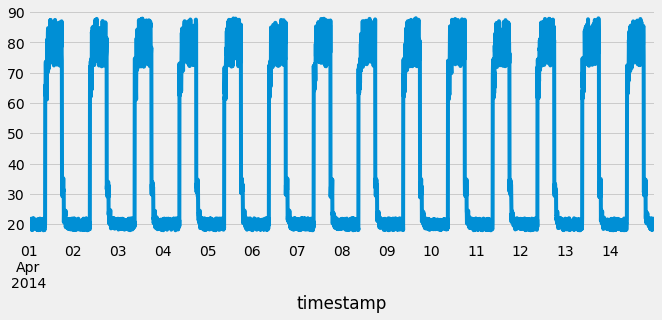

In [13]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

In [14]:
# Read a comma-separated values (csv) file into DataFrame.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# Return the first n rows (5 by default).
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# Generate descriptive statistics.
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [17]:
# Ask pandas for the 'value' column.
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [18]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_daily_jumpsup.shape

(4032, 1)

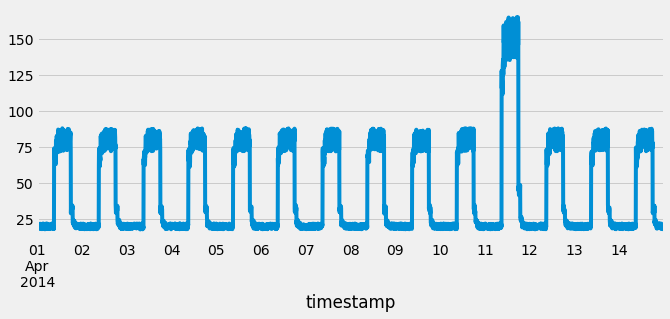

In [19]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## Preprocessing

***

In [20]:
# Get the mean.
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [21]:
# Get the standard deviation.
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [22]:
# Subtract the mean from each value in the DataFrame and divide that value by the standard deviation.
df_train_vals = (df_small_noise - train_mean) / train_std

In [23]:
# Return the first n rows (5 by default).
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [24]:
# Create a new column 'less_mean' which is the result of subtracting the mean from each value 
# in the DataFrame
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()

# Create a new column 'div_std' which is the result of dividing the 'less_mean' by the 
# standard deviation.
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [25]:
# Take a look at the new columns in 'df_small_noise'
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [26]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.43835333580657, 5.018912974813406e-15, 1.691768418476429e-16)

In [27]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.07712228126252, 28.077122281262515, 0.9999999999999999)

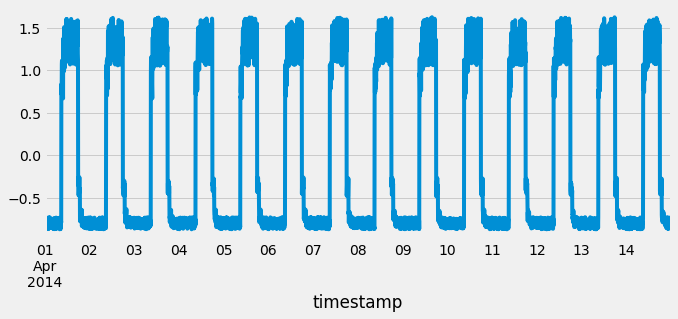

In [28]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [29]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_train_vals.shape

(4032, 1)

In [30]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [31]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [32]:
# Remove brackets.
len(L) - win_size + 1

10

In [33]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])


[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [34]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [35]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [36]:
# Window size for the DataFrame.
window_size = 288

In [37]:
# Function to generate the windows in the DataFrame.
def windows(vals, N=window_size):
  # 
  L = []
  # 
  for i in range(len(vals) - N + 1):
    # 
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [38]:
# Use def windows to generate the training data for x.
x_train = windows(df_train_vals)

In [39]:
# Look at the first and last values in x_train using indexing.
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [40]:
# Look at the first and last values in x_train using iloc.
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [41]:
# Returns a tuple that shows how many dimension the DataFrame has.
x_train.shape

(3745, 288, 1)

In [42]:
# Ask pandas for the 'value' column and use '.values' to return a Numpy representation of the DataFrame.
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [43]:
# Look at the first element (window) of 'x_train' and use 'flatten' to return 
# a copy of the array collapsed into one dimension.
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

Recreate the same plot of df_train_vals as above but with more control over it than we have above.

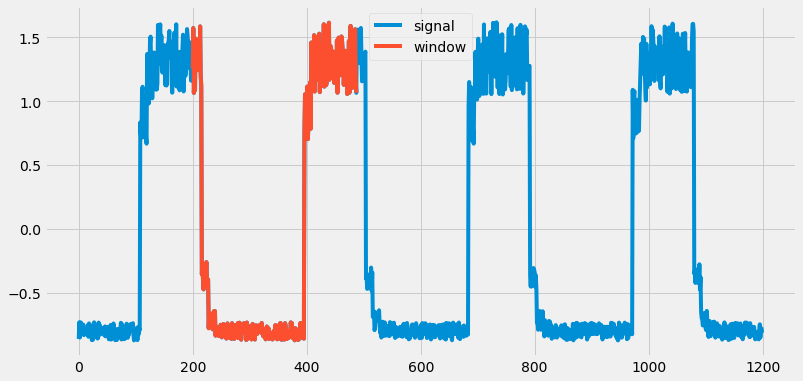

In [44]:
# Change this value to look at different windows.
window_no = 200

# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(12, 6))

# y values are pulled from the 'df_train_vals' DF.
y = df_train_vals['value'].values[:1200]

# We want x values that are spaced out by the same interval as the y values.
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# plot DataFame.
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

# Create animation here.

## Neural Network

In [45]:
x_train.shape

(3745, 288, 1)

Keras will let us use multidimensional input layers, but generally speaking, we use 1 dimensional input layers. This means that all of the values in the window are going into the neural network as the input in one fell swoop. There are 288 nodes or neurons at the start that are coming in with 288 values, each of which is a value from the input dataset. 

In [46]:
# Using 1 dimensional input layer.
layers = [
  # 288 nodes, 1 dimention.
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # Conv1D layer
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Dropout layer
  keras.layers.Dropout(rate=0.2),
  # Conv1D layer
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Conv1DTranspose layer
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Dropout layer
  keras.layers.Dropout(rate=0.2),
  # Conv1DTranspose layer
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Conv1DTranspose layer
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [47]:
# Model (come back to it).
model = keras.Sequential(layers)

In [48]:
# Adam Optimizer.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [49]:
# Loss function "mse".
model.compile(optimizer=optimizer, loss="mse")

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [51]:
# Epochs (come back to it intersting that the x_train is passed to model.fit twice)
# 10% is held back for validation.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
27/27 [==============================] - 2s 32ms/step - loss: 0.5189 - val_loss: 0.1198
Epoch 2/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0795 - val_loss: 0.0431
Epoch 3/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0578 - val_loss: 0.0368
Epoch 4/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0495 - val_loss: 0.0316
Epoch 5/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0434 - val_loss: 0.0283
Epoch 6/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0383 - val_loss: 0.0252
Epoch 7/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0342 - val_loss: 0.0238
Epoch 8/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0310 - val_loss: 0.0228
Epoch 9/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0283 - val_loss: 0.0228
Epoch 10/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0265 - val_loss: 0.0224
Epoch 11/

## Evaluation

***

The neural network keeps a histrory of how the fitting procedure went. Figure out what they mean (difference between loss and val_loss).

In [52]:
history.history["loss"]

[0.5189372301101685,
 0.07953186333179474,
 0.0577828474342823,
 0.04947098717093468,
 0.04342180863022804,
 0.03825755417346954,
 0.03416140377521515,
 0.030951738357543945,
 0.028342319652438164,
 0.026466134935617447,
 0.025006834417581558,
 0.02367713302373886,
 0.022555844858288765,
 0.021618716418743134,
 0.020781952887773514]

In [53]:
history.history["val_loss"]

[0.11983514577150345,
 0.04309624060988426,
 0.03682214766740799,
 0.031579457223415375,
 0.02834446169435978,
 0.02515006996691227,
 0.02382803149521351,
 0.02278119884431362,
 0.02282491885125637,
 0.022366466000676155,
 0.023006051778793335,
 0.025221219286322594,
 0.02465505711734295,
 0.025911938399076462,
 0.026779737323522568]

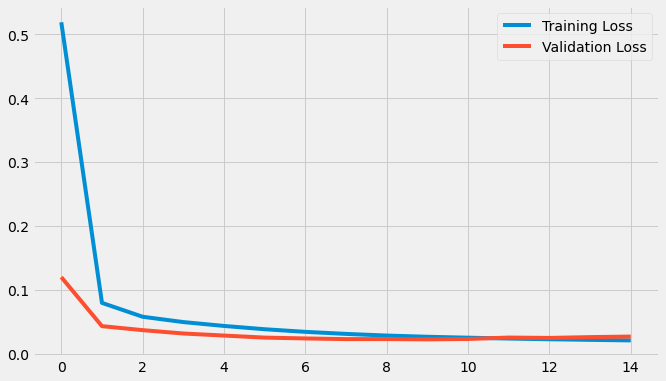

In [54]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
# Training Loss
ax.plot(history.history["loss"], label="Training Loss")
# Validation Loss
ax.plot(history.history["val_loss"], label="Validation Loss")
# Legend
ax.legend();

In [55]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 0s 3ms/step


In [56]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

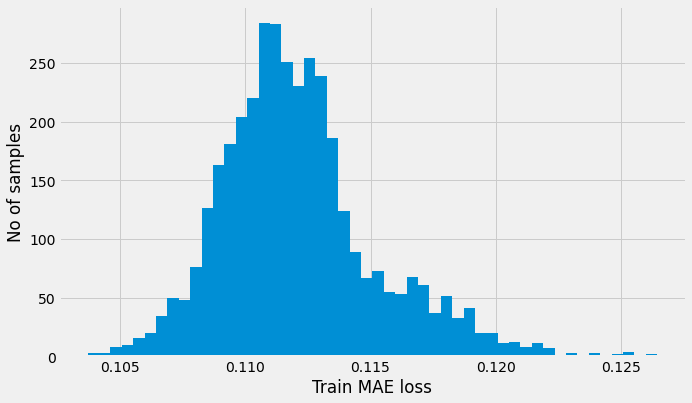

In [57]:
# Plotting.
fig, ax = plt.subplots(figsize=(10, 6))
# See if the predictions are any good.
ax.hist(train_mae_loss, bins=50)
# x lebal.
ax.set_xlabel("Train MAE loss")
# y label.
ax.set_ylabel("No of samples");

In [58]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Look at threshold.
threshold

0.12643974864108012

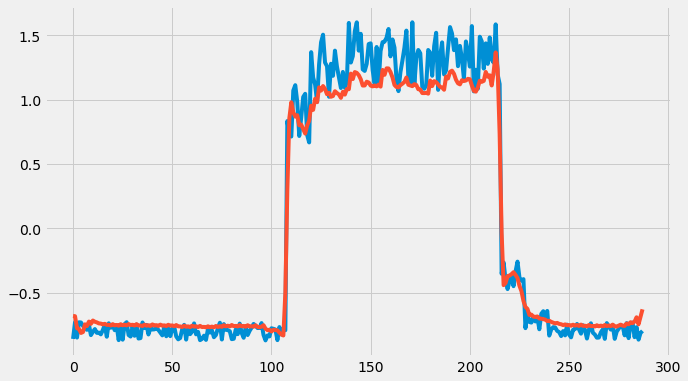

In [59]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Training set.
ax.plot(x_train[0])

# Against what the neural network is predicting the output should be.
ax.plot(x_train_pred[0]);

In [60]:
# Subtract training mean from df_daily_jumpsup.
df_test_value = (df_daily_jumpsup - train_mean) / train_std

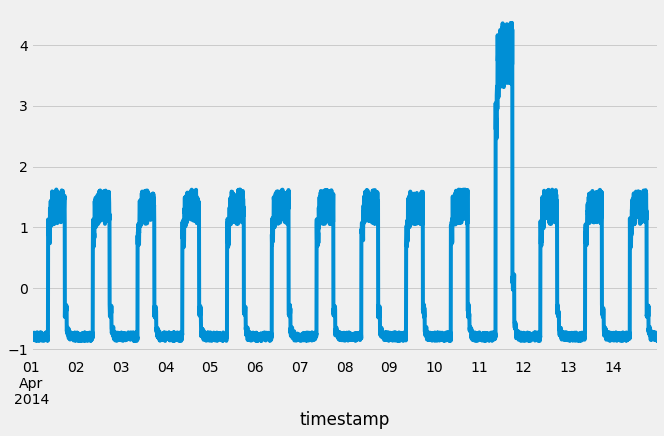

In [61]:
# Plotting.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the test values.
df_test_value.plot(legend=False, ax=ax);

In [62]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [63]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 3ms/step


In [64]:
# Test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.10746948],
       [0.10942408],
       [0.11030981],
       ...,
       [0.11313951],
       [0.11177362],
       [0.11115714]])

In [65]:
# Why does this need to be re-shaped?
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.10746948, 0.10942408, 0.11030981, ..., 0.11313951, 0.11177362,
       0.11115714])

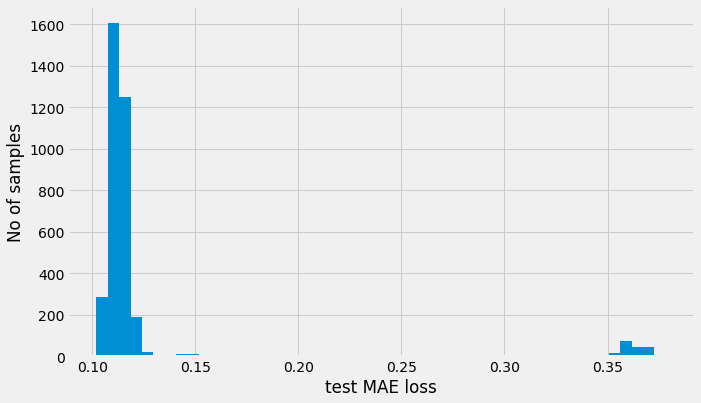

In [66]:
# Plotting.
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram.
ax.hist(test_mae_loss, bins=50)

# x label test MAE loss.
ax.set_xlabel("test MAE loss")

# y label No of samples.
ax.set_ylabel("No of samples");

In [67]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

399

In [68]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [69]:
# Gets the subset of df_daily_jumpsup where there are anomalies.
df_subset = df_daily_jumpsup.iloc[inds]

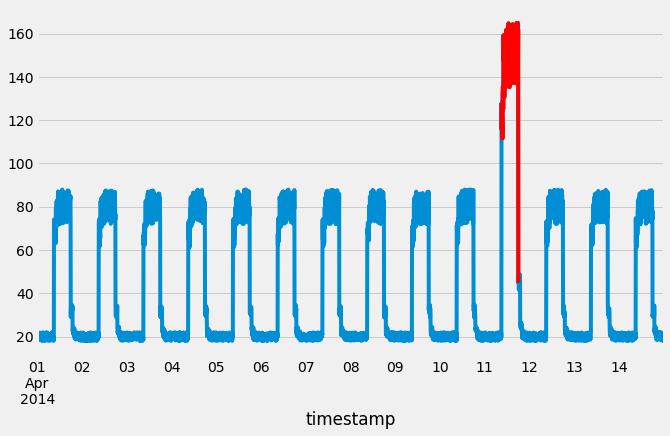

In [70]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
df_daily_jumpsup.plot(legend=False, ax=ax)

# Plot anamolies in red.
df_subset.plot(legend=False, ax=ax, color="r");

***

## References

***

[01] [pyimagesearch.com - Intro to anomaly detection with OpenCV, Computer Vision, and scikit-learn](https://pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/)<br>
[02] [avinetworks.com - Anomaly Detection](https://avinetworks.com/glossary/anomaly-detection/)<br>
[03] [wikipedia.org - Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection)<br>
[04] []()<br>
[05] []()<br>
[06] []()<br>
[07] []()<br>
[08] []()<br>
[09] []()<br>
[10] []()<br>
[11] []()<br>
[12] []()<br>
[14] []()<br>
[15] []()<br>